# HDP spell-sound analyzer

developed by Kow Kuroda (kow.kuroda@gmail.com)

This Jupyter Notebook was prepared for Kow Kuroda's paper presented at the 41st Annual Meeting of Japanese Cognitive Science Society, Tokyo (2024/10/14).

## History

- 2024/08/19 Cython を使った cy_gen_ngrams を利用可能にした;
- 2024/09/02 n-gram 生成の generic function を導入し，コードを簡略化;
- 2024/09/06 term の階層クラスタリングを実装;
- 2024/10/28 (skippy) n-gram 生成処理を高速化 (Cython を使わなくてもそれなりに速くなった);
- 2024/11/23 word の文字への分割処理を改善 (diacritics が分離する可能性を抑制);
- 2025/03/01 Irish の spell-IPA symbol 対応データを追加;
- 2025/07/25 i) implemented handling of extended skippy (xsk) n-grams, ii) refactored code;

In [122]:
#!pip install -U pyLDAvis
#!pip install -U pandas

In [ ]:
check = False

In [ ]:
## imports
import pprint as pp
import unicodedata

In [ ]:
## 一つ上の階層のファイルを見るように設定
import os, sys
sys.path.append(os.path.join(os.path.dirname("__file__"), '..'))

In [125]:
## 必要に応じてCython のインストール
#!conda install cython -y

In [126]:
## Cython module の生成 (必要に応じて)
#!python clean setup.py build_ext --inplace

In [127]:
## Cython を使うかどうか
use_Cython = False
if use_Cython:
    %load_ext Cython

In [128]:
## term settings
term_classes        = [ 'spell', 'sound' ]
term_class          = term_classes[0]
print(f"term_class: {term_class}")

ngram_is_inclusive  = True
print(f"ngram_is_inclusive: {ngram_is_inclusive}")

inclusion_degree    = None
print(f"inclusion_degree: {inclusion_degree}")

## doc settings
max_doc_size        = 11
min_doc_size        =  3
print(f"max_doc_size: {max_doc_size}")
print(f"min_doc_size: {min_doc_size}")

### boundary handling
mark_boundaries     = True # if True, n_for_ngram needs to be one-size bigger
print(f"mark_boundaries: {mark_boundaries}")
boundary_mark       = "#"
print(f"boundary_mark: {boundary_mark}")

## term setting
print(f"term_class: {term_class}")
term_is_skippy      = True
print(f"term_is_skippy: {term_is_skippy}")

skippy_means_extended = True
print(f"skippy_means_extended: {skippy_means_extended}")

n_for_ngram         = 4
print(f"n_for_ngram: {n_for_ngram}")
max_gap_ratio       = 1.0
max_gap_size        = round(max_doc_size * max_gap_ratio)
print(f"max_gap_size: {max_gap_size}")

## symbols
gap_mark            = "…"
seg_joint           = ""

### accent handling
suppress_accents    = True
accent_marks        = [ "ˈ", "ˌ" ] 
if term_class == 'sound':
    if suppress_accents:
        accent_status = "-unaccented"
    else:
        accent_stratus = "-accented"
else:
    accent_status = ""
print(f"accent_status: {accent_status}")

## define term_type
if term_class == 'spell':
    if term_is_skippy:
        if skippy_means_extended:
            term_type = f"sp_xsk{n_for_ngram}gram"
        else:
            term_type = f"sp_sk{n_for_ngram}gram"
    else:
        term_type = f"sp_{n_for_ngram}gram"
else:
    if term_is_skippy:
        if skippy_means_extended:
            term_type = f"sn_xsk{n_for_ngram}gram"
        else:
            term_type = f"sn_sk{n_for_ngram}gram"
    else:
        term_type = f"sn_{n_for_ngram}gram"
print(f"term_type: {term_type}")

term_class: spell
ngram_is_inclusive: True
inclusion_degree: None
max_doc_size: 11
min_doc_size: 3
mark_boundaries: True
boundary_mark: #
term_class: spell
term_is_skippy: True
skippy_means_extended: True
n_for_ngram: 4
max_gap_size: 11
accent_status: 
term_type: sp_xsk4gram


In [129]:
## target language
## a key must be part of a file name 
target_lang_dict = {    'en_US' : 'English (US)',
                        'en_UK' : 'English (UK)',
                        'en_N_only' : 'English noun (WN)',
                        'en_V_only' : 'English verb (WN)',
                        'en_A_only' : 'English adj (WN)',
                        'en_R_only' : 'English adv (WN)',
                        'ar'    : 'Arabic',
                        'de'    : 'German',
                        'de_N_only' : 'German Nouns',
                        'de_non_N_only' : 'German Non-nouns',
                        'eo'    : 'Esperanto',
                        'es_ES' : 'Spanish (Spain)',
                        'es_MX' : 'Spanish (Mexico)',
                        'fi'    : 'Finnish',
                        'fr_FR' : 'French (France)',
                        'fr_QC' : 'French (Quebec)',
                        'is'    : 'Icelandic',
                        'ir'    : 'Irish',
                        'nl'    : 'Dutch',
                        'ro'    : 'Romanian',
                        'sw'    : 'Swahili' }
## proper language selection
target_lang_keys = [    'en_US', # 0
                        'en_UK', # 1
                        'en_N_only', # 2
                        'en_V_only', # 3
                        'en_A_only', # 4
                        'en_R_only', # 5
                        'ar', # 6
                        'de', # 7
                        'de_N_only', # 8
                        'de_non_N_only', # 9
                        'eo', 'es_ES', 'es_MX',
                        'fi', 'fr_FR', 'fr_QC',
                        'is', 'nl', 'ro', 'sw',
                        'ir' # This lacks sound
                    ]

## check
target_lang_key  = target_lang_keys[11]
print(f"target_lang_key: {target_lang_key}")
print(f"target lang: {target_lang_dict[target_lang_key]} [{target_lang_key}]")

## target_attr [effective only for Irish]
target_class = ""

#target_class = None # This causes an unrediable error
if target_lang_key == "ir":
    target_classes = [ 'adjectives', 'nouns', 'verbs' ]
    target_class = f"-{target_classes[3]}"
print(f"target_class: {target_class}")

target_lang_key: es_ES
target lang: Spanish (Spain) [es_ES]
target_class: 


In [130]:
## LDA/HDP
# number of terms listed for a given topic
n_docs_to_show     = 15
n_terms_to_show    = 20
n_terms_to_save    = 120

# saving output
save_LDAvis          = False
save_topic_structure = False

# hierarchical clustering
hc_sampling_rate     = 0.02

In [ ]:
## term filtering
apply_term_filtering = True

## The following parameters need to be relatively large to prevent "Row sum not equal 1" error
min_bot_size       = min_doc_size # 3
term_min_freq       = 3
print(f"term_minfreq: {term_min_freq}")

abuse_thresholds = [0.05, 0.1, 0.33, 0.5, 0.67, 0.9, 0.95]
# larger value selects shorter units, smaller value selects longer units
#abuse_threshold    = 0.05
abuse_threshold = abuse_thresholds[-1]
print(f"abuse_threshold: {abuse_threshold}")

term_minfreq: 3
abuse_threshold: 0.95


In [ ]:
## sampling
source_sampling           = True
print(f"source_sampling: {source_sampling}")

source_sampling_rate      = 0.5
print(f"source_sampling_rate: {source_sampling_rate}")

source_sampling_max_size  = 2000
print(f"source_sampling_max_size: {source_sampling_max_size}")

second_sampling           = False
print(f"second_sampling: {second_sampling}")

second_sampling_rate      = 0.7
if second_sampling:
    print(f"second_sampling_rate: {second_sampling_rate}")

source_sampling: True
source_sampling_rate: 0.5
source_sampling_max_size: 2000
second_sampling: False


In [133]:
## set target files
import glob
import pprint as pp

# intialize
target_files = [ ]
# data1
data_dir1     = "data/open-dict-ipa/data1"
target_files  = glob.glob(f"{data_dir1}/*")
# data2
data_dir2     = "data/open-dict-ipa/data1a"
target2_files = glob.glob(f"{data_dir2}/*")
target_files.extend(target2_files)
# data3
data_dir3     = "data/wn3"
extend_data_with_data3 = False
if extend_data_with_data3:
    target3_files = glob.glob(f"{data_dir3}/*")
    target_files.extend(target3_files)
# data4
data_dir4     = "data/irish"
extend_data_with_data4 = False
if extend_data_with_data4:
    target4_files = glob.glob(f"{data_dir4}/*")
    target_files.extend(target4_files)
# data5
data_dir5     = "data/custom-ipa"
extend_data_with_data5 = True
if extend_data_with_data5:
    target5_files = glob.glob(f"{data_dir5}/*")
    target_files.extend(target5_files)
#
target_files = sorted([ file for file in target_files if ".csv" in file ])
pp.pprint(target_files)

['data/custom-ipa/ir.csv',
 'data/open-dict-ipa/data1/ar.csv.gz',
 'data/open-dict-ipa/data1/de.csv.gz',
 'data/open-dict-ipa/data1/en_UK.csv.gz',
 'data/open-dict-ipa/data1/en_US.csv',
 'data/open-dict-ipa/data1/en_US.csv.gz',
 'data/open-dict-ipa/data1/eo.csv.gz',
 'data/open-dict-ipa/data1/es_ES.csv.gz',
 'data/open-dict-ipa/data1/es_MX.csv.gz',
 'data/open-dict-ipa/data1/fa.csv.gz',
 'data/open-dict-ipa/data1/fi.csv.gz',
 'data/open-dict-ipa/data1/fr_FR.csv.gz',
 'data/open-dict-ipa/data1/fr_QC.csv.gz',
 'data/open-dict-ipa/data1/is.csv.gz',
 'data/open-dict-ipa/data1/ja.csv.gz',
 'data/open-dict-ipa/data1/jam.csv.gz',
 'data/open-dict-ipa/data1/ma.csv.gz',
 'data/open-dict-ipa/data1/nb.csv.gz',
 'data/open-dict-ipa/data1/nl.csv.gz',
 'data/open-dict-ipa/data1/or.csv.gz',
 'data/open-dict-ipa/data1/ro.csv.gz',
 'data/open-dict-ipa/data1/sv.csv.gz',
 'data/open-dict-ipa/data1/sw.csv.gz',
 'data/open-dict-ipa/data1/vi_C.csv.gz',
 'data/open-dict-ipa/data1/vi_N.csv.gz',
 'data/open-di

In [134]:
## get source data from files
import pandas as pd
import gzip
#target_language_key = "en_US" # can be changed to get other languages
#if target_class != "" or target_class is not None:
if target_class != "":
    target_file = [ f for f in target_files if target_lang_key in f and target_class in f ][0]
else:
    target_file = [ f for f in target_files if target_lang_key in f ][0]
print(f"processing: {target_file}")
##
targets_POS = False
if target_lang_key == "ir" and targets_POS:
    col_names = ['spell', 'POS']
else:
    col_names = ['spell', 'sound']

##
if target_file.endswith(".gz"):
    with gzip.open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
else:
    with open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )

## normalize characters
raw_df['spell'] = raw_df['spell'].apply(lambda x: unicodedata.normalize('NFC', str(x)))

## modify sound
try:
    sounds = raw_df['sound'].apply(lambda x: x.strip('/') )
    sounds = [ x.split("/,")[0] for x in sounds ] # picks up only the first of multiple entries
    raw_df['sound'] = sounds
except (AttributeError, KeyError):
    pass
#
raw_df.sample(10)

processing: data/open-dict-ipa/data1/es_ES.csv.gz


spell             sound
21410         aducirles         aðuθiɾles
507395   repartiéndoles   repaˈɾtjendoles
365266       imbursarás       imbuɾsaˈɾas
493887        redimible         reðimiβle
454204       picotearos        pikoteaɾos
518615  retrotrajéremos  retɾotɾaˈxeɾemos
8858       acaronaríais     akaɾonaˈɾiais
234847   electrificarán   elektɾifikaˈɾan
108539         carillón          kaɾiˈʎon
70876        asimilarlo        asimilaɾlo

In [135]:
## source sampling
len(raw_df)
if source_sampling:
	print(f"source sampling applied")
	if len(raw_df) >= source_sampling_max_size:
		raw_df = raw_df.sample(source_sampling_max_size)
	else:
		raw_df = raw_df.sample(round(len(raw_df) * source_sampling_rate))
## remove accent marking
if suppress_accents:
	try:
		raw_df['sound'] = raw_df['sound'].apply(lambda x: "".join([ y for y in list(x) if y not in accent_marks ]))
	except KeyError:
		pass
## add boudary marks
if mark_boundaries:
	raw_df['spell'] = raw_df['spell'].apply(lambda x: f"{boundary_mark}{x}{boundary_mark}")
	try:
		raw_df['sound'] = raw_df['sound'].apply(lambda x: f"{boundary_mark}{x}{boundary_mark}")
	except KeyError:
		pass
#
print(raw_df)

source sampling applied
                      spell               sound
4318            #abortemos#         #aβoɾtemos#
553683   #superlativamente#  #supeɾlatiβamente#
337820            #fórmula#           #foɾmula#
544886      #solapamientos#     #solapamjentos#
380148  #interrelacionarle#  #interelaθjonaɾle#
...                     ...                 ...
472838      #propiciatorio#     #pɾopiθjatoɾjo#
131091      #concordasteis#     #koŋkoɾðasteis#
141126        #convalidado#       #kombaliðaðo#
28928       #aherrumbraban#       #aerumbɾaβan#
577075       #trifurquemos#       #tɾifuɾkemos#

[2000 rows x 2 columns]


In [ ]:
## generate 1-grams for spell and sound
import unicodedata
## spell
raw_df['sp_1gram'] = raw_df['spell'].apply(lambda x: [*unicodedata.normalize('NFC', x)])

# add column of size
raw_df['sp_size'] = raw_df['sp_1gram'].apply(lambda x: len(x))

# add column of count of '-' inside
raw_df['hyphen'] = raw_df['sp_1gram'].apply(lambda x: list(x).count("-"))

# add column of count of '.' inside
raw_df['period'] = raw_df['sp_1gram'].apply(lambda x: list(x).count("."))

## sound
# takes the first entry, removes '/' around
try:
    raw_df['sn_1gram'] = raw_df['sound'].apply(lambda x: list(x) )
except (TypeError, KeyError):
    pass

# add column of size
try:
    raw_df['sn_size'] = raw_df['sn_1gram'].apply(lambda x: len(x))
except KeyError:
    pass

## check
raw_df

spell               sound  \
4318            #abortemos#         #aβoɾtemos#   
553683   #superlativamente#  #supeɾlatiβamente#   
337820            #fórmula#           #foɾmula#   
544886      #solapamientos#     #solapamjentos#   
380148  #interrelacionarle#  #interelaθjonaɾle#   
...                     ...                 ...   
472838      #propiciatorio#     #pɾopiθjatoɾjo#   
131091      #concordasteis#     #koŋkoɾðasteis#   
141126        #convalidado#       #kombaliðaðo#   
28928       #aherrumbraban#       #aerumbɾaβan#   
577075       #trifurquemos#       #tɾifuɾkemos#   

                                                 sp_1gram  sp_size  hyphen  \
4318                    [#, a, b, o, r, t, e, m, o, s, #]       11       0   
553683  [#, s, u, p, e, r, l, a, t, i, v, a, m, e, n, ...       18       0   
337820                        [#, f, ó, r, m, u, l, a, #]        9       0   
544886      [#, s, o, l, a, p, a, m, i, e, n, t, o, s, #]       15       0   
380148  [#, i, n, t, e, r, r, e, l, a, c, i, o, n, a, ...       19       0   
...                                                   ...      ...     ...   
472838      [#, p, r, o, p, i, c, i, a, t, o, r, i, o, #]       15       0   
131091      [#, c, o, n, c, o, r, d, a, s, t, e, i, s, #]       15       0   
141126            [#, c, o, n, v, a, l, i, d, a, d, o, #]       13       0   
28928       [#, a, h, e, r, r, u, m, b, r, a, b, a, n, #]       15       0   
577075         [#, t, r, i, f, u, r, q, u, e, m, o, s, #]       14       0   

        period                                           sn_1gram  sn_size  
4318         0                  [#, a, β, o, ɾ, t, e, m, o, s, #]       11  
553683       0  [#, s, u, p, e, ɾ, l, a, t, i, β, a, m, e, n, ...       18  
337820       0                        [#, f, o, ɾ, m, u, l, a, #]        9  
544886       0      [#, s, o, l, a, p, a, m, j, e, n, t, o, s, #]       15  
380148       0  [#, i, n, t, e, r, e, l, a, θ, j, o, n, a, ɾ, ...       18  
...        ...                                                ...      ...  
472838       0      [#, p, ɾ, o, p, i, θ, j, a, t, o, ɾ, j, o, #]       15  
131091       0      [#, k, o, ŋ, k, o, ɾ, ð, a, s, t, e, i, s, #]       15  
141126       0            [#, k, o, m, b, a, l, i, ð, a, ð, o, #]       13  
28928        0            [#, a, e, r, u, m, b, ɾ, a, β, a, n, #]       13  
577075       0            [#, t, ɾ, i, f, u, ɾ, k, e, m, o, s, #]       13  

[2000 rows x 8 columns]

In [137]:
## filtering raw_data by size
print(f"term_type: {term_type}")
if "sp_" in term_type:
    df_filtered = raw_df[ (raw_df['sp_size'] <= max_doc_size) & (raw_df['sp_size'] >= min_doc_size) & (raw_df['hyphen'] == 0) & (raw_df['period'] == 0) ]
else:
    df_filtered = raw_df[ (raw_df['sn_size'] <= max_doc_size) & (raw_df['sn_size'] >= min_doc_size) ]
#
df_filtered

term_type: sp_xsk4gram


spell        sound                           sp_1gram  sp_size  \
4318    #abortemos#  #aβoɾtemos#  [#, a, b, o, r, t, e, m, o, s, #]       11   
337820    #fórmula#    #foɾmula#        [#, f, ó, r, m, u, l, a, #]        9   
418706     #misará#     #misaɾa#           [#, m, i, s, a, r, á, #]        8   
71507   #asomareis#  #asomaɾeis#  [#, a, s, o, m, a, r, e, i, s, #]       11   
221598     #diario#     #djaɾjo#           [#, d, i, a, r, i, o, #]        8   
...             ...          ...                                ...      ...   
591272   #vivieran#   #biβjeɾan#     [#, v, i, v, i, e, r, a, n, #]       10   
478779   #quitamos#    #kitamos#     [#, q, u, i, t, a, m, o, s, #]       10   
118575  #chupaseis#  #tʃupaseis#  [#, c, h, u, p, a, s, e, i, s, #]       11   
481138  #raqueados#   #rakeaðos#  [#, r, a, q, u, e, a, d, o, s, #]       11   
579829   #tullidos#    #tuʎiðos#     [#, t, u, l, l, i, d, o, s, #]       10   

        hyphen  period                           sn_1gram  sn_size  
4318         0       0  [#, a, β, o, ɾ, t, e, m, o, s, #]       11  
337820       0       0        [#, f, o, ɾ, m, u, l, a, #]        9  
418706       0       0           [#, m, i, s, a, ɾ, a, #]        8  
71507        0       0  [#, a, s, o, m, a, ɾ, e, i, s, #]       11  
221598       0       0           [#, d, j, a, ɾ, j, o, #]        8  
...        ...     ...                                ...      ...  
591272       0       0     [#, b, i, β, j, e, ɾ, a, n, #]       10  
478779       0       0        [#, k, i, t, a, m, o, s, #]        9  
118575       0       0  [#, t, ʃ, u, p, a, s, e, i, s, #]       11  
481138       0       0     [#, r, a, k, e, a, ð, o, s, #]       10  
579829       0       0        [#, t, u, ʎ, i, ð, o, s, #]        9  

[701 rows x 8 columns]

In [138]:
## define df after second sampling if any
len(df_filtered)
if second_sampling:
    df = df_filtered.sample(round(len(df_filtered) * second_sampling_rate))
else:
    df = df_filtered
len(df)

701

In [139]:
## generic function for n-gram generation
def add_ngram_to_df (dfx, n_for_ngram: int, skippy: bool, prefix: str = "", seg_joint: str = "", missing_mark: str = gap_mark, max_distance = None, inclusive: bool = ngram_is_inclusive, skippy_means_extended: bool = False, inclusion_degree = None, use_Cython: bool = False, check: bool = False):
    """
    generic function for adding n-gram column to df with a specified n for ngram
    """
    ## variables
    source_var = f"{prefix}1gram"
    print(f"source_var: {source_var}")
    if skippy:
        if skippy_means_extended:
            target_var = f"{prefix}xsk{n_for_ngram}gram"
        else:
            target_var = f"{prefix}sk{n_for_ngram}gram"
    else:
        target_var = f"{prefix}{n_for_ngram}gram"
    print(f"target_var: {target_var}")
    
    ##
    unigrams = dfx[source_var]
    if use_Cython:
        import cy_gen_ngrams
        if skippy:
            if skippy_means_extended:
                ngrams = unigrams.apply(lambda x: cy_gen_ngrams.gen_ext_skippy_ngrams(x, n = n_for_ngram, sep = seg_joint, missing_mark = missing_mark, max_distance = max_distance, check = check) )
            else:
                ngrams = unigrams.apply(lambda x: cy_gen_ngrams.gen_skippy_ngrams(x, n = n_for_ngram, sep = seg_joint, missing_mark = missing_mark, max_distance = max_distance, check = check) )
            
        else:
            ngrams = unigrams.apply(lambda x: cy_gen_ngrams.gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check) )
    else:
        import gen_ngrams
        if skippy:
            if skippy_means_extended:
                ngrams = unigrams.apply(lambda x: gen_ngrams.gen_ext_skippy_ngrams(x, n = n_for_ngram, sep = seg_joint, missing_mark = missing_mark, max_distance = max_distance, check = check) )
            else:
                ngrams = unigrams.apply(lambda x: gen_ngrams.gen_skippy_ngrams(x, n = n_for_ngram, sep = seg_joint, missing_mark = missing_mark, max_distance = max_distance, check = check) )
        else:
            ngrams = unigrams.apply(lambda x: gen_ngrams.gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check) )
    ## 包括的 n-gramの生成
    if inclusive and n_for_ngram > 1:
        if inclusion_degree is None:
            min_size = 1
        else:
            min_size = (n_for_ngram - inclusion_degree)
        print(f"min_size: {min_size}")
        assert min_size >= 0
        if skippy and n_for_ngram > 2:
            if skippy_means_extended:
                supplement_var = f"{prefix}xsk{n_for_ngram - 1}gram"
            else:
                supplement_var = f"{prefix}sk{n_for_ngram - 1}gram"
        else:
            supplement_var = f"{prefix}{n_for_ngram - 1}gram"
        print(f"supplement_var: {supplement_var}")
        for i, g in enumerate(ngrams):
            supplement = [ x for x in list(dfx[supplement_var])[i] if len(x) >= min_size ]
            if len(supplement) > 0:
                g.extend(supplement)
    ## 変数の追加
    dfx[target_var] = ngrams
    ## check result
    print(dfx[target_var])

# Spell

In [140]:
## spell n-grams
for i in range(1, n_for_ngram + 1):
    add_ngram_to_df (df, n_for_ngram = i, prefix = "sp_", seg_joint = "", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_1gram
4318      [#, a, b, o, r, t, e, m, o, s, #]
337820          [#, f, ó, r, m, u, l, a, #]
418706             [#, m, i, s, a, r, á, #]
71507     [#, a, s, o, m, a, r, e, i, s, #]
221598             [#, d, i, a, r, i, o, #]
                        ...                
591272       [#, v, i, v, i, e, r, a, n, #]
478779       [#, q, u, i, t, a, m, o, s, #]
118575    [#, c, h, u, p, a, s, e, i, s, #]
481138    [#, r, a, q, u, e, a, d, o, s, #]
579829       [#, t, u, l, l, i, d, o, s, #]
Name: sp_1gram, Length: 701, dtype: object
source_var: sp_1gram
target_var: sp_2gram
min_size: 1
supplement_var: sp_1gram
4318      [#a, ab, bo, or, rt, te, em, mo, os, s#, #, a,...
337820    [#f, fó, ór, rm, mu, ul, la, a#, #, f, ó, r, m...
418706    [#m, mi, is, sa, ar, rá, á#, #, m, i, s, a, r,...
71507     [#a, as, so, om, ma, ar, re, ei, is, s#, #, a,...
221598    [#d, di, ia, ar, ri, io, o#, #, d, i, a, r, i,...
                                ...                 

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_30355/4116675474.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams
/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_30355/4116675474.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams
/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_30355/4116675474.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [ ]:
## frequencies of n-grams
prefix = "sp_"
ngram_is_skippy = False
if ngram_is_skippy:
    if skippy_means_extended:
        skippiness = "xsk"
    else:
        skippiness = "sk"
else:
    skippiness = ""

most_n = 30
for i in range(1, n_for_ngram + 1): 
    var_name = f'{prefix}{skippiness}{i}gram'
    print(f"var_name: {var_name}")
    G = [ ]
    [ G.extend([x for x in L if len(x.replace(gap_mark, "")) == i]) for L in df[var_name] ]

    import collections
    g = collections.Counter(G).most_common(most_n = 30)
    print(g)

var_name: sp_1gram
[('#', 1402), ('a', 884), ('e', 601), ('r', 520), ('s', 439), ('o', 349), ('i', 346), ('n', 297), ('l', 250), ('d', 223), ('c', 213), ('t', 203), ('m', 184), ('u', 162), ('p', 118), ('b', 106), ('g', 80), ('é', 58), ('v', 56), ('j', 50), ('h', 48), ('z', 45), ('f', 44), ('á', 44), ('í', 36), ('ó', 33), ('q', 17), ('ñ', 15), ('y', 13), ('ú', 6)]
var_name: sp_2gram
[('s#', 222), ('ar', 205), ('as', 135), ('re', 115), ('#a', 113), ('a#', 110), ('ra', 105), ('en', 96), ('es', 95), ('e#', 83), ('ad', 82), ('#e', 80), ('la', 77), ('n#', 77), ('o#', 72), ('os', 69), ('is', 64), ('an', 63), ('ta', 62), ('er', 62), ('#d', 61), ('de', 61), ('#c', 58), ('se', 56), ('#r', 56), ('da', 55), ('al', 53), ('ro', 52), ('ca', 52), ('#m', 50)]
var_name: sp_3gram
[('as#', 78), ('os#', 53), ('is#', 44), ('#de', 43), ('#re', 41), ('#en', 40), ('are', 37), ('ase', 37), ('es#', 36), ('ara', 33), ('an#', 32), ('ada', 30), ('des', 30), ('en#', 29), ('ado', 29), ('aba', 27), ('re#', 25), ('mos'

In [142]:
df[[ var for var in df.columns if "sp_" in var ]]

sp_1gram  sp_size  \
4318    [#, a, b, o, r, t, e, m, o, s, #]       11   
337820        [#, f, ó, r, m, u, l, a, #]        9   
418706           [#, m, i, s, a, r, á, #]        8   
71507   [#, a, s, o, m, a, r, e, i, s, #]       11   
221598           [#, d, i, a, r, i, o, #]        8   
...                                   ...      ...   
591272     [#, v, i, v, i, e, r, a, n, #]       10   
478779     [#, q, u, i, t, a, m, o, s, #]       10   
118575  [#, c, h, u, p, a, s, e, i, s, #]       11   
481138  [#, r, a, q, u, e, a, d, o, s, #]       11   
579829     [#, t, u, l, l, i, d, o, s, #]       10   

                                                 sp_2gram  \
4318    [#a, ab, bo, or, rt, te, em, mo, os, s#, #, a,...   
337820  [#f, fó, ór, rm, mu, ul, la, a#, #, f, ó, r, m...   
418706  [#m, mi, is, sa, ar, rá, á#, #, m, i, s, a, r,...   
71507   [#a, as, so, om, ma, ar, re, ei, is, s#, #, a,...   
221598  [#d, di, ia, ar, ri, io, o#, #, d, i, a, r, i,...   
...                                                   ...   
591272  [#v, vi, iv, vi, ie, er, ra, an, n#, #, v, i, ...   
478779  [#q, qu, ui, it, ta, am, mo, os, s#, #, q, u, ...   
118575  [#c, ch, hu, up, pa, as, se, ei, is, s#, #, c,...   
481138  [#r, ra, aq, qu, ue, ea, ad, do, os, s#, #, r,...   
579829  [#t, tu, ul, ll, li, id, do, os, s#, #, t, u, ...   

                                                 sp_3gram  \
4318    [#ab, abo, bor, ort, rte, tem, emo, mos, os#, ...   
337820  [#fó, fór, órm, rmu, mul, ula, la#, #f, fó, ór...   
418706  [#mi, mis, isa, sar, ará, rá#, #m, mi, is, sa,...   
71507   [#as, aso, som, oma, mar, are, rei, eis, is#, ...   
221598  [#di, dia, iar, ari, rio, io#, #d, di, ia, ar,...   
...                                                   ...   
591272  [#vi, viv, ivi, vie, ier, era, ran, an#, #v, v...   
478779  [#qu, qui, uit, ita, tam, amo, mos, os#, #q, q...   
118575  [#ch, chu, hup, upa, pas, ase, sei, eis, is#, ...   
481138  [#ra, raq, aqu, que, uea, ead, ado, dos, os#, ...   
579829  [#tu, tul, ull, lli, lid, ido, dos, os#, #t, t...   

                                                 sp_4gram  
4318    [#abo, abor, bort, orte, rtem, temo, emos, mos...  
337820  [#fór, fórm, órmu, rmul, mula, ula#, #fó, fór,...  
418706  [#mis, misa, isar, sará, ará#, #mi, mis, isa, ...  
71507   [#aso, asom, soma, omar, mare, arei, reis, eis...  
221598  [#dia, diar, iari, ario, rio#, #di, dia, iar, ...  
...                                                   ...  
591272  [#viv, vivi, ivie, vier, iera, eran, ran#, #vi...  
478779  [#qui, quit, uita, itam, tamo, amos, mos#, #qu...  
118575  [#chu, chup, hupa, upas, pase, asei, seis, eis...  
481138  [#raq, raqu, aque, quea, uead, eado, ados, dos...  
579829  [#tul, tull, ulli, llid, lido, idos, dos#, #tu...  

[701 rows x 5 columns]

In [143]:
## spell skippy n-grams
for i in range(1, n_for_ngram + 1):
    add_ngram_to_df(df, n_for_ngram = i, prefix = "sp_", skippy = True, skippy_means_extended = skippy_means_extended, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_xsk1gram
4318      [#…, …a…, …b…, …o…, …r…, …t…, …e…, …m…, …o…, …...
337820          [#…, …f…, …ó…, …r…, …m…, …u…, …l…, …a…, …#]
418706               [#…, …m…, …i…, …s…, …a…, …r…, …á…, …#]
71507     [#…, …a…, …s…, …o…, …m…, …a…, …r…, …e…, …i…, …...
221598               [#…, …d…, …i…, …a…, …r…, …i…, …o…, …#]
                                ...                        
591272     [#…, …v…, …i…, …v…, …i…, …e…, …r…, …a…, …n…, …#]
478779     [#…, …q…, …u…, …i…, …t…, …a…, …m…, …o…, …s…, …#]
118575    [#…, …c…, …h…, …u…, …p…, …a…, …s…, …e…, …i…, …...
481138    [#…, …r…, …a…, …q…, …u…, …e…, …a…, …d…, …o…, …...
579829     [#…, …t…, …u…, …l…, …l…, …i…, …d…, …o…, …s…, …#]
Name: sp_xsk1gram, Length: 701, dtype: object
source_var: sp_1gram
target_var: sp_xsk2gram
min_size: 1
supplement_var: sp_1gram
4318      [#a…, #…b…, #…o…, #…r…, #…t…, #…e…, #…m…, #…o…...
337820    [#f…, #…ó…, #…r…, #…m…, #…u…, #…l…, #…a…, #…#,...
418706    [#m…, #…i…, #…s…, #…a…, #…r…, #…á…, #

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_30355/4116675474.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams
/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_30355/4116675474.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


min_size: 1
supplement_var: sp_xsk2gram
4318      [#…ab…, #…a…o…, #…a…r…, #…a…t…, #…a…e…, #…a…m…...
337820    [#…fó…, #…f…r…, #…f…m…, #…f…u…, #…f…l…, #…f…a…...
418706    [#…mi…, #…m…s…, #…m…a…, #…m…r…, #…m…á…, #…m…#,...
71507     [#…as…, #…a…o…, #…a…m…, #…a…a…, #…a…r…, #…a…e…...
221598    [#…di…, #…d…a…, #…d…r…, #…d…i…, #…d…o…, #…d…#,...
                                ...                        
591272    [#…vi…, #…v…v…, #…v…i…, #…v…e…, #…v…r…, #…v…a…...
478779    [#…qu…, #…q…i…, #…q…t…, #…q…a…, #…q…m…, #…q…o…...
118575    [#…ch…, #…c…u…, #…c…p…, #…c…a…, #…c…s…, #…c…e…...
481138    [#…ra…, #…r…q…, #…r…u…, #…r…e…, #…r…a…, #…r…d…...
579829    [#…tu…, #…t…l…, #…t…l…, #…t…i…, #…t…d…, #…t…o…...
Name: sp_xsk3gram, Length: 701, dtype: object
source_var: sp_1gram
target_var: sp_xsk4gram


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_30355/4116675474.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


min_size: 1
supplement_var: sp_xsk3gram
4318      [#…a…bo…, #…a…b…r…, #…a…b…t…, #…a…b…e…, #…a…b…...
337820    [#…f…ór…, #…f…ó…m…, #…f…ó…u…, #…f…ó…l…, #…f…ó…...
418706    [#…m…is…, #…m…i…a…, #…m…i…r…, #…m…i…á…, #…m…i…...
71507     [#…a…so…, #…a…s…m…, #…a…s…a…, #…a…s…r…, #…a…s…...
221598    [#…d…ia…, #…d…i…r…, #…d…i…i…, #…d…i…o…, #…d…i…...
                                ...                        
591272    [#…v…iv…, #…v…i…i…, #…v…i…e…, #…v…i…r…, #…v…i…...
478779    [#…q…ui…, #…q…u…t…, #…q…u…a…, #…q…u…m…, #…q…u…...
118575    [#…c…hu…, #…c…h…p…, #…c…h…a…, #…c…h…s…, #…c…h…...
481138    [#…r…aq…, #…r…a…u…, #…r…a…e…, #…r…a…a…, #…r…a…...
579829    [#…t…ul…, #…t…u…l…, #…t…u…i…, #…t…u…d…, #…t…u…...
Name: sp_xsk4gram, Length: 701, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_30355/4116675474.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [ ]:
## frequencies of skippy n-grams
prefix = "sp_"
ngram_is_skippy = True
if ngram_is_skippy:
    if skippy_means_extended:
        skippiness = "xsk"
    else:
        skippiness = "sk"
else:
    skippiness = ""

most_n = 30
for i in range(2, n_for_ngram + 1):
    var_name = f'{prefix}{skippiness}{i}gram'
    print(f"var_name: {var_name}")
    G = [ ]
    [ G.extend([x for x in L if len(x.replace(gap_mark, "")) == i]) for L in df[var_name] ]

    import collections
    g = collections.Counter(G).most_common(most_n)
    print(g)

var_name: sp_xsk2gram
[('…a…#', 774), ('#…a…', 771), ('#…#', 701), ('#…e…', 521), ('…e…#', 518), ('…r…#', 491), ('#…r…', 464), ('…a…a…', 422), ('#…s…', 408), ('…i…#', 346), ('#…o…', 341), ('#…i…', 332), ('…e…a…', 317), ('#…n…', 286), ('…o…#', 277), ('…a…e…', 259), ('…a…s…', 250), ('…l…#', 244), ('#…l…', 226), ('…s#', 222), ('…n…#', 220), ('…r…a…', 219), ('…s…#', 217), ('…c…#', 213), ('…d…#', 206), ('…ar…', 205), ('…t…#', 203), ('…m…#', 184), ('…a…o…', 181), ('…i…a…', 181)]
var_name: sp_xsk3gram
[('#…a…#', 774), ('#…e…#', 518), ('#…r…#', 491), ('#…a…a…', 422), ('#…i…#', 346), ('…a…r…#', 328), ('…a…a…#', 321), ('#…e…a…', 317), ('…a…s#', 283), ('#…o…#', 277), ('…e…a…#', 273), ('#…a…e…', 259), ('#…a…s…', 250), ('…r…a…#', 245), ('#…l…#', 244), ('#…s#', 222), ('#…n…#', 220), ('#…r…a…', 219), ('#…s…#', 217), ('…e…r…#', 215), ('#…c…#', 213), ('#…d…#', 206), ('#…ar…', 205), ('#…t…#', 203), ('#…m…#', 184), ('#…a…o…', 181), ('#…i…a…', 181), ('#…e…r…', 173), ('…r…e…#', 170), ('#…e…e…', 168)]
var_n

In [ ]:
## frequencies of skippy n-grams
prefix = "sp_"
ngram_is_skippy = True
if ngram_is_skippy:
    if skippy_means_extended:
        skippiness = "xsk"
    else:
        skippiness = "sk"
else:
    skippiness = ""

most_n = 30
for i in range(1, n_for_ngram + 1):
    var_name = f'{prefix}{skippiness}{i}gram'
    print(f"var_name: {var_name}")
    G = [ ]
    [ G.extend([x for x in L if len(x.replace(gap_mark, "")) == i]) for L in df[var_name] ]

    import collections
    g = collections.Counter(G).most_common(most_n)
    print(g)

var_name: sp_xsk1gram
[('…a…', 884), ('#…', 701), ('…#', 701), ('…e…', 601), ('…r…', 520), ('…s…', 439), ('…o…', 349), ('…i…', 346), ('…n…', 297), ('…l…', 250), ('…d…', 223), ('…c…', 213), ('…t…', 203), ('…m…', 184), ('…u…', 162), ('…p…', 118), ('…b…', 106), ('…g…', 80), ('…é…', 58), ('…v…', 56), ('…j…', 50), ('…h…', 48), ('…z…', 45), ('…f…', 44), ('…á…', 44), ('…í…', 36), ('…ó…', 33), ('…q…', 17), ('…ñ…', 15), ('…y…', 13)]
var_name: sp_xsk2gram
[('…a…#', 774), ('#…a…', 771), ('#…#', 701), ('#…e…', 521), ('…e…#', 518), ('…r…#', 491), ('#…r…', 464), ('…a…a…', 422), ('#…s…', 408), ('…i…#', 346), ('#…o…', 341), ('#…i…', 332), ('…e…a…', 317), ('#…n…', 286), ('…o…#', 277), ('…a…e…', 259), ('…a…s…', 250), ('…l…#', 244), ('#…l…', 226), ('…s#', 222), ('…n…#', 220), ('…r…a…', 219), ('…s…#', 217), ('…c…#', 213), ('…d…#', 206), ('…ar…', 205), ('…t…#', 203), ('…m…#', 184), ('…a…o…', 181), ('…i…a…', 181)]
var_name: sp_xsk3gram
[('#…a…#', 774), ('#…e…#', 518), ('#…r…#', 491), ('#…a…a…', 422), ('#…i…

In [146]:
## check result
target_vars = [ 'spell' ]
target_vars.extend([ f"sp_{i}gram" for i in range(1, n_for_ngram + 1) ])
if skippy_means_extended:
    target_vars.extend([ f"sp_xsk{i}gram" for i in range(2, n_for_ngram + 1) ])
else:
    target_vars.extend([ f"sp_sk{i}gram" for i in range(2, n_for_ngram + 1) ])
#
df[target_vars]

spell                           sp_1gram  \
4318    #abortemos#  [#, a, b, o, r, t, e, m, o, s, #]   
337820    #fórmula#        [#, f, ó, r, m, u, l, a, #]   
418706     #misará#           [#, m, i, s, a, r, á, #]   
71507   #asomareis#  [#, a, s, o, m, a, r, e, i, s, #]   
221598     #diario#           [#, d, i, a, r, i, o, #]   
...             ...                                ...   
591272   #vivieran#     [#, v, i, v, i, e, r, a, n, #]   
478779   #quitamos#     [#, q, u, i, t, a, m, o, s, #]   
118575  #chupaseis#  [#, c, h, u, p, a, s, e, i, s, #]   
481138  #raqueados#  [#, r, a, q, u, e, a, d, o, s, #]   
579829   #tullidos#     [#, t, u, l, l, i, d, o, s, #]   

                                                 sp_2gram  \
4318    [#a, ab, bo, or, rt, te, em, mo, os, s#, #, a,...   
337820  [#f, fó, ór, rm, mu, ul, la, a#, #, f, ó, r, m...   
418706  [#m, mi, is, sa, ar, rá, á#, #, m, i, s, a, r,...   
71507   [#a, as, so, om, ma, ar, re, ei, is, s#, #, a,...   
221598  [#d, di, ia, ar, ri, io, o#, #, d, i, a, r, i,...   
...                                                   ...   
591272  [#v, vi, iv, vi, ie, er, ra, an, n#, #, v, i, ...   
478779  [#q, qu, ui, it, ta, am, mo, os, s#, #, q, u, ...   
118575  [#c, ch, hu, up, pa, as, se, ei, is, s#, #, c,...   
481138  [#r, ra, aq, qu, ue, ea, ad, do, os, s#, #, r,...   
579829  [#t, tu, ul, ll, li, id, do, os, s#, #, t, u, ...   

                                                 sp_3gram  \
4318    [#ab, abo, bor, ort, rte, tem, emo, mos, os#, ...   
337820  [#fó, fór, órm, rmu, mul, ula, la#, #f, fó, ór...   
418706  [#mi, mis, isa, sar, ará, rá#, #m, mi, is, sa,...   
71507   [#as, aso, som, oma, mar, are, rei, eis, is#, ...   
221598  [#di, dia, iar, ari, rio, io#, #d, di, ia, ar,...   
...                                                   ...   
591272  [#vi, viv, ivi, vie, ier, era, ran, an#, #v, v...   
478779  [#qu, qui, uit, ita, tam, amo, mos, os#, #q, q...   
118575  [#ch, chu, hup, upa, pas, ase, sei, eis, is#, ...   
481138  [#ra, raq, aqu, que, uea, ead, ado, dos, os#, ...   
579829  [#tu, tul, ull, lli, lid, ido, dos, os#, #t, t...   

                                                 sp_4gram  \
4318    [#abo, abor, bort, orte, rtem, temo, emos, mos...   
337820  [#fór, fórm, órmu, rmul, mula, ula#, #fó, fór,...   
418706  [#mis, misa, isar, sará, ará#, #mi, mis, isa, ...   
71507   [#aso, asom, soma, omar, mare, arei, reis, eis...   
221598  [#dia, diar, iari, ario, rio#, #di, dia, iar, ...   
...                                                   ...   
591272  [#viv, vivi, ivie, vier, iera, eran, ran#, #vi...   
478779  [#qui, quit, uita, itam, tamo, amos, mos#, #qu...   
118575  [#chu, chup, hupa, upas, pase, asei, seis, eis...   
481138  [#raq, raqu, aque, quea, uead, eado, ados, dos...   
579829  [#tul, tull, ulli, llid, lido, idos, dos#, #tu...   

                                              sp_xsk2gram  \
4318    [#a…, #…b…, #…o…, #…r…, #…t…, #…e…, #…m…, #…o…...   
337820  [#f…, #…ó…, #…r…, #…m…, #…u…, #…l…, #…a…, #…#,...   
418706  [#m…, #…i…, #…s…, #…a…, #…r…, #…á…, #…#, …mi…,...   
71507   [#a…, #…s…, #…o…, #…m…, #…a…, #…r…, #…e…, #…i…...   
221598  [#d…, #…i…, #…a…, #…r…, #…i…, #…o…, #…#, …di…,...   
...                                                   ...   
591272  [#v…, #…i…, #…v…, #…i…, #…e…, #…r…, #…a…, #…n…...   
478779  [#q…, #…u…, #…i…, #…t…, #…a…, #…m…, #…o…, #…s…...   
118575  [#c…, #…h…, #…u…, #…p…, #…a…, #…s…, #…e…, #…i…...   
481138  [#r…, #…a…, #…q…, #…u…, #…e…, #…a…, #…d…, #…o…...   
579829  [#t…, #…u…, #…l…, #…l…, #…i…, #…d…, #…o…, #…s…...   

                                              sp_xsk3gram  \
4318    [#…ab…, #…a…o…, #…a…r…, #…a…t…, #…a…e…, #…a…m…...   
337820  [#…fó…, #…f…r…, #…f…m…, #…f…u…, #…f…l…, #…f…a…...   
418706  [#…mi…, #…m…s…, #…m…a…, #…m…r…, #…m…á…, #…m…#,...   
71507   [#…as…, #…a…o…, #…a…m…, #…a…a…, #…a…r…, #…a…e…...   
221598  [#…di…, #…d…a…, #…d…r…, #…d…i…, #…d…o…, #…d…#,...   
...                

# Sound

In [147]:
## sound n-grams
for i in range(2, n_for_ngram + 1):
    add_ngram_to_df (df, n_for_ngram = i, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_2gram
min_size: 1
supplement_var: sn_1gram
4318      [#a, aβ, βo, oɾ, ɾt, te, em, mo, os, s#, #, a,...
337820    [#f, fo, oɾ, ɾm, mu, ul, la, a#, #, f, o, ɾ, m...
418706    [#m, mi, is, sa, aɾ, ɾa, a#, #, m, i, s, a, ɾ,...
71507     [#a, as, so, om, ma, aɾ, ɾe, ei, is, s#, #, a,...
221598    [#d, dj, ja, aɾ, ɾj, jo, o#, #, d, j, a, ɾ, j,...
                                ...                        
591272    [#b, bi, iβ, βj, je, eɾ, ɾa, an, n#, #, b, i, ...
478779    [#k, ki, it, ta, am, mo, os, s#, #, k, i, t, a...
118575    [#t, tʃ, ʃu, up, pa, as, se, ei, is, s#, #, t,...
481138    [#r, ra, ak, ke, ea, að, ðo, os, s#, #, r, a, ...
579829    [#t, tu, uʎ, ʎi, ið, ðo, os, s#, #, t, u, ʎ, i...
Name: sn_2gram, Length: 701, dtype: object
source_var: sn_1gram
target_var: sn_3gram
min_size: 1
supplement_var: sn_2gram
4318      [#aβ, aβo, βoɾ, oɾt, ɾte, tem, emo, mos, os#, ...
337820    [#fo, foɾ, oɾm, ɾmu, mul, ula, la#, #f, fo, oɾ...
418706    [#mi, mis

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_30355/4116675474.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams
/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_30355/4116675474.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams
/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_30355/4116675474.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [148]:
## sound skippy n-grams
for i in range(2, n_for_ngram + 1):
    add_ngram_to_df (df, n_for_ngram = i, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_sk2gram
min_size: 1
supplement_var: sn_1gram
4318      [#a, #…β, #…o, #…ɾ, #…t, #…e, #…m, #…o, #…s, #...
337820    [#f, #…o, #…ɾ, #…m, #…u, #…l, #…a, #…#, fo, f…...
418706    [#m, #…i, #…s, #…a, #…ɾ, #…a, #…#, mi, m…s, m…...
71507     [#a, #…s, #…o, #…m, #…a, #…ɾ, #…e, #…i, #…s, #...
221598    [#d, #…j, #…a, #…ɾ, #…j, #…o, #…#, dj, d…a, d…...
                                ...                        
591272    [#b, #…i, #…β, #…j, #…e, #…ɾ, #…a, #…n, #…#, b...
478779    [#k, #…i, #…t, #…a, #…m, #…o, #…s, #…#, ki, k…...
118575    [#t, #…ʃ, #…u, #…p, #…a, #…s, #…e, #…i, #…s, #...
481138    [#r, #…a, #…k, #…e, #…a, #…ð, #…o, #…s, #…#, r...
579829    [#t, #…u, #…ʎ, #…i, #…ð, #…o, #…s, #…#, tu, t…...
Name: sn_sk2gram, Length: 701, dtype: object
source_var: sn_1gram
target_var: sn_sk3gram
min_size: 1
supplement_var: sn_sk2gram
4318      [#aβ, #a…o, #a…ɾ, #a…t, #a…e, #a…m, #a…o, #a…s...
337820    [#fo, #f…ɾ, #f…m, #f…u, #f…l, #f…a, #f…#, #…oɾ...
418706    [

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_30355/4116675474.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams
/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_30355/4116675474.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


min_size: 1
supplement_var: sn_sk3gram
4318      [#aβo, #aβ…ɾ, #aβ…t, #aβ…e, #aβ…m, #aβ…o, #aβ…...
337820    [#foɾ, #fo…m, #fo…u, #fo…l, #fo…a, #fo…#, #f…ɾ...
418706    [#mis, #mi…a, #mi…ɾ, #mi…a, #mi…#, #m…sa, #m…s...
71507     [#aso, #as…m, #as…a, #as…ɾ, #as…e, #as…i, #as…...
221598    [#dja, #dj…ɾ, #dj…j, #dj…o, #dj…#, #d…aɾ, #d…a...
                                ...                        
591272    [#biβ, #bi…j, #bi…e, #bi…ɾ, #bi…a, #bi…n, #bi…...
478779    [#kit, #ki…a, #ki…m, #ki…o, #ki…s, #ki…#, #k…t...
118575    [#tʃu, #tʃ…p, #tʃ…a, #tʃ…s, #tʃ…e, #tʃ…i, #tʃ…...
481138    [#rak, #ra…e, #ra…a, #ra…ð, #ra…o, #ra…s, #ra…...
579829    [#tuʎ, #tu…i, #tu…ð, #tu…o, #tu…s, #tu…#, #t…ʎ...
Name: sn_sk4gram, Length: 701, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_30355/4116675474.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [149]:
## check result
dropped_vars = [ 'sp_size', 'hyphen', 'period', 'sn_size' ]
if term_class == 'spell':
    extra = [ 'sn_1gram', 'sn_2gram', 'sn_3gram', 'sn_4gram',
             'sn_sk2gram', 'sn_sk3gram', 'sn_sk4gram' ]
    dropped_vars.extend(extra)
    target_vars = [ x for x in df.columns if not x in dropped_vars ]
else:
    extra = [ 'sp_1gram', 'sp_2gram', 'sp_3gram', 'sp_4gram',
             'sp_sk2gram', 'sp_sk3gram', 'sp_sk4gram' ]
    dropped_vars.extend(extra)
    target_vars = [ x for x in df.columns if not x in dropped_vars ]    
#
df[target_vars]

spell        sound                           sp_1gram  \
4318    #abortemos#  #aβoɾtemos#  [#, a, b, o, r, t, e, m, o, s, #]   
337820    #fórmula#    #foɾmula#        [#, f, ó, r, m, u, l, a, #]   
418706     #misará#     #misaɾa#           [#, m, i, s, a, r, á, #]   
71507   #asomareis#  #asomaɾeis#  [#, a, s, o, m, a, r, e, i, s, #]   
221598     #diario#     #djaɾjo#           [#, d, i, a, r, i, o, #]   
...             ...          ...                                ...   
591272   #vivieran#   #biβjeɾan#     [#, v, i, v, i, e, r, a, n, #]   
478779   #quitamos#    #kitamos#     [#, q, u, i, t, a, m, o, s, #]   
118575  #chupaseis#  #tʃupaseis#  [#, c, h, u, p, a, s, e, i, s, #]   
481138  #raqueados#   #rakeaðos#  [#, r, a, q, u, e, a, d, o, s, #]   
579829   #tullidos#    #tuʎiðos#     [#, t, u, l, l, i, d, o, s, #]   

                                                 sp_2gram  \
4318    [#a, ab, bo, or, rt, te, em, mo, os, s#, #, a,...   
337820  [#f, fó, ór, rm, mu, ul, la, a#, #, f, ó, r, m...   
418706  [#m, mi, is, sa, ar, rá, á#, #, m, i, s, a, r,...   
71507   [#a, as, so, om, ma, ar, re, ei, is, s#, #, a,...   
221598  [#d, di, ia, ar, ri, io, o#, #, d, i, a, r, i,...   
...                                                   ...   
591272  [#v, vi, iv, vi, ie, er, ra, an, n#, #, v, i, ...   
478779  [#q, qu, ui, it, ta, am, mo, os, s#, #, q, u, ...   
118575  [#c, ch, hu, up, pa, as, se, ei, is, s#, #, c,...   
481138  [#r, ra, aq, qu, ue, ea, ad, do, os, s#, #, r,...   
579829  [#t, tu, ul, ll, li, id, do, os, s#, #, t, u, ...   

                                                 sp_3gram  \
4318    [#ab, abo, bor, ort, rte, tem, emo, mos, os#, ...   
337820  [#fó, fór, órm, rmu, mul, ula, la#, #f, fó, ór...   
418706  [#mi, mis, isa, sar, ará, rá#, #m, mi, is, sa,...   
71507   [#as, aso, som, oma, mar, are, rei, eis, is#, ...   
221598  [#di, dia, iar, ari, rio, io#, #d, di, ia, ar,...   
...                                                   ...   
591272  [#vi, viv, ivi, vie, ier, era, ran, an#, #v, v...   
478779  [#qu, qui, uit, ita, tam, amo, mos, os#, #q, q...   
118575  [#ch, chu, hup, upa, pas, ase, sei, eis, is#, ...   
481138  [#ra, raq, aqu, que, uea, ead, ado, dos, os#, ...   
579829  [#tu, tul, ull, lli, lid, ido, dos, os#, #t, t...   

                                                 sp_4gram  \
4318    [#abo, abor, bort, orte, rtem, temo, emos, mos...   
337820  [#fór, fórm, órmu, rmul, mula, ula#, #fó, fór,...   
418706  [#mis, misa, isar, sará, ará#, #mi, mis, isa, ...   
71507   [#aso, asom, soma, omar, mare, arei, reis, eis...   
221598  [#dia, diar, iari, ario, rio#, #di, dia, iar, ...   
...                                                   ...   
591272  [#viv, vivi, ivie, vier, iera, eran, ran#, #vi...   
478779  [#qui, quit, uita, itam, tamo, amos, mos#, #qu...   
118575  [#chu, chup, hupa, upas, pase, asei, seis, eis...   
481138  [#raq, raqu, aque, quea, uead, eado, ados, dos...   
579829  [#tul, tull, ulli, llid, lido, idos, dos#, #tu...   

                                              sp_xsk1gram  \
4318    [#…, …a…, …b…, …o…, …r…, …t…, …e…, …m…, …o…, …...   
337820        [#…, …f…, …ó…, …r…, …m…, …u…, …l…, …a…, …#]   
418706             [#…, …m…, …i…, …s…, …a…, …r…, …á…, …#]   
71507   [#…, …a…, …s…, …o…, …m…, …a…, …r…, …e…, …i…, …...   
221598             [#…, …d…, …i…, …a…, …r…, …i…, …o…, …#]   
...                                                   ...   
591272   [#…, …v…, …i…, …v…, …i…, …e…, …r…, …a…, …n…, …#]   
478779   [#…, …q…, …u…, …i…, …t…, …a…, …m…, …o…, …s…, …#]   
118575  [#…, …c…, …h…, …u…, …p…, …a…, …s…, …e…, …i…, …...   
481138  [#…, …r…, …a…, …q…, …u…, …e…, …a…, …d…, …o…, …...   
579829   [#…, …t…, …u…, …l…, …l…, …i…, …d…, …o…, …s…, …#]   

                                              sp_xsk2gram  \
4318    [#a…, #…b…, #…o…, #…r…, #…t…, #…e…, #…m…, #…o…...   
337820  [#f…, #…ó…, #…r…, #…m…, #…u…, #…l…, #…a…, #…#,...   
418706  [#m…, #…i…, #…s…, #…a…, #…r…, #…á…, #…

# Analysis

In [150]:
#import matplotlib
#matplotlib.font_manager.findSystemFonts(fontpaths = None, fontext = 'ttf')

In [151]:
#import HDP_utils

In [152]:
## select data type and define doc_dict
import random
if "sp_" in term_type:
    base_type = "spell"
else:
    base_type = "sound"
doc_dict = { i: x for i, x in enumerate(df[base_type]) }
## check
random.sample(doc_dict.items(), 10)

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_30355/1181347170.py:9: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.sample(doc_dict.items(), 10)


[(58, '#plomado#'),
 (137, '#toparte#'),
 (249, '#azuzare#'),
 (611, '#entercar#'),
 (247, '#remolida#'),
 (114, '#achinarás#'),
 (415, '#duré#'),
 (284, '#tísicas#'),
 (9, '#causó#'),
 (377, '#amándote#')]

In [172]:
## select bots for analysis
enable_term_change = False # if you want to change term_type to save time and energy
if enable_term_change:
	term_type = 'sp_sk4gram'
	print(f"(changed) term_type: {term_type}")

## bot stands for 'bag-of-terms', a generalization of 'bag-of-words'
bots = [ x for x in df[term_type] if len(x) > min_bot_size ] # Crucially

In [ ]:
if check:
	import random
	random.sample(bots, 1)

In [ ]:
## generate dictionary
from gensim.corpora import Dictionary
diction = Dictionary(bots)
print(diction)

#apply_term_filtering = False
if apply_term_filtering:
    print(f"term filtering applied")
    diction.filter_extremes(no_below = term_min_freq, no_above = abuse_threshold)
else:
    print(f"term filtering not applied")
## check
print(diction)

## generate DTM
corpus = [ diction.doc2bow(bot) for bot in bots if len(bot) >= min_bot_size ] # Crucially

Dictionary<60350 unique tokens: ['#', '#a…', '#…#', '#…ab…', '#…a…#']...>
term filtering applied
Dictionary<17476 unique tokens: ['#a…', '#…ab…', '#…a…#', '#…a…bo…', '#…a…b…#']...>


In [155]:
## sanitize corpus: HDP の場合は必須の処理
corpus = [ doc for doc in corpus if len(doc) > 0 ] # filter out empty rows 

In [156]:
## HDP (n_topics = 15)
import gensim.models
import pyLDAvis.gensim

max_n_topics = 15
hdp15 = gensim.models.HdpModel(corpus, diction, T = max_n_topics, random_state = 1)
vis_data15 = pyLDAvis.gensim.prepare(hdp15, corpus, diction)
pyLDAvis.display(vis_data15)

In [157]:
## save LDAvis output as a html file
#save_LDAvis = True
if save_LDAvis:
	lang_dir_name = target_lang_dict[target_lang_key].split()[0]
	vis_output = f"results/LDAvis/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-HDP-max_ntop{max_n_topics}-{term_type}{accent_status}.html"
	pyLDAvis.save_html(vis_data15, vis_output)

In [158]:
## import helper functions
import numpy as np
import HDP_helper
reload_module = True
if reload_module:
    import importlib
    importlib.reload(HDP_helper)

In [159]:
## topic investigation
target_hdp = hdp15
documents_topics = np.zeros([target_hdp.m_T, len(corpus)])
for doc_id, c in enumerate(corpus):
    for topic_id, prob in target_hdp[c]:
        documents_topics[topic_id][doc_id] = prob

target_hdp.optimal_ordering()
for topic_id, probs in enumerate(documents_topics):
    print(f"==============")
    topic_t = target_hdp.print_topic(topic_id, topn = n_terms_to_show)
    print(f"topic_id {topic_id}: {HDP_helper.reformat_topic (topic_t, n_terms_to_show)}")
    print(f"nonzero count: ", len(probs.nonzero()[0]))
    for doc_id in probs.argsort()[::-1][:n_docs_to_show]:
        doc = doc_dict[doc_id]
        print(f"\t{probs[doc_id]:0.4f}: {doc}")

topic_id 0: 0.002 * a + 0.001 * #…a… + 0.001 * …a…# + 0.001 * #…a…# + 0.001 * e + 0.001 * #…e…# + 0.001 * #…e… + 0.001 * …e…# + 0.001 * r + 0.001 * …r…# + 0.001 * #…r…# + 0.001 * #…r… + 0.001 * …e…a… + 0.001 * #…e…a… + 0.001 * s + 0.001 * n + 0.001 * …a…r…# + 0.001 * #…e…r…# + 0.001 * #…a…a… + 0.001 * …a…a…
nonzero count:  631
	0.9986: #escurares#
	0.9986: #pajareare#
	0.9986: #recalabas#
	0.9986: #repeladas#
	0.9986: #espadadas#
	0.9986: #recebaran#
	0.9985: #enmonaría#
	0.9985: #desecaría#
	0.9985: #enmaremos#
	0.9985: #endeudara#
	0.9985: #enduraría#
	0.9985: #enumeraré#
	0.9985: #educareis#
	0.9985: #retrajere#
	0.9985: #enhenaría#
topic_id 1: 0.001 * a + 0.001 * …a…# + 0.001 * #…a…# + 0.001 * #…a… + 0.001 * e + 0.001 * #…e… + 0.001 * s + 0.001 * #…e…# + 0.001 * #…s… + 0.001 * …e…# + 0.001 * #…r… + 0.001 * …r…# + 0.001 * #…t…# + 0.001 * r + 0.001 * #…r…# + 0.001 * …a…a… + 0.001 * n + 0.001 * #…a…s# + 0.001 * #…a…a… + 0.001 * #…i…#
nonzero count:  463
	0.9984: #almenases#
	0.9982: #

In [160]:
## save topic structures
if save_topic_structure:
    #hdp.get_topics() # =/= show_topics()
    #hdp.print_topics()
    hdp_topics = hdp15.show_topics(num_topics = max_n_topics,
                                num_words = n_terms_to_save, formatted = False)
    hdp_dict = { tid: values for tid, values in hdp_topics }
    ## convert to Pandas dataframe
    topics_df = pd.DataFrame.from_dict(hdp_dict)
    hdp15_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
    topics_df.to_csv(hdp15_topics_out, header = False, index = None)
    print(f"saved: {hdp15_topics_out}")

17476 rows remain after density filtering, discarding 0 rows
16637 rows remain after size filtering, discarding 839 rows
33 rows remain after size filtering, discarding 16604 rows


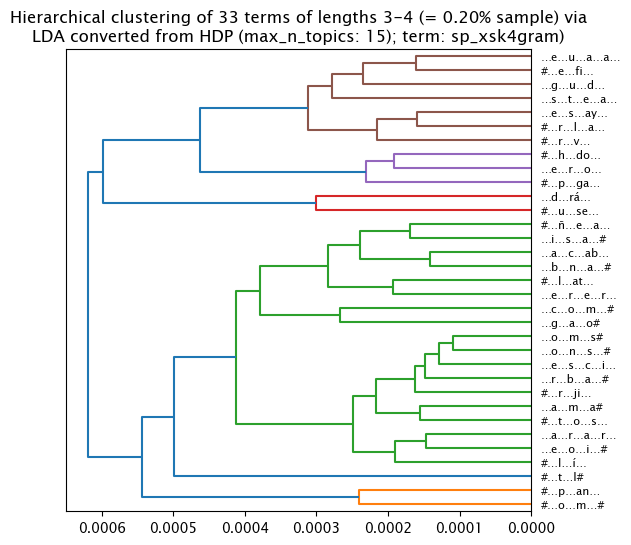

In [161]:
## term の階層クラスタリング: max_n_topics の値に拠ってparameters の最適値は異なる
HDP_helper.hc_clustering_terms_from_hdp (hdp15, diction, term_type = term_type, n_topics= 15, lowest_density = 0.0002, max_length = n_for_ngram, min_length = 3, sampling_rate = 0.002, gap_mark = gap_mark, use_CJK = False, check = False)

In [162]:
## HDP (n_topics = 45)
import gensim.models
import pyLDAvis.gensim

max_n_topics = 45
hdp45 = gensim.models.HdpModel(corpus, diction, T = max_n_topics, random_state = 1)
vis_data45 = pyLDAvis.gensim.prepare(hdp45, corpus, diction)
pyLDAvis.display(vis_data45)

In [163]:
## save LDAvis output as a html file
lang_dir_name = target_lang_dict[target_lang_key].split()[0]
#save_LDAvis = True
if save_LDAvis:
	vis_output = f"results/LDAvis/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-HDP-max_ntop{max_n_topics}-{term_type}{accent_status}.html"
	pyLDAvis.save_html(vis_data45, vis_output)

In [164]:
## save topic structures
if save_topic_structure:
    #hdp.get_topics() # =/= show_topics()
    #hdp.print_topics()
    hdp_topics = hdp45.show_topics(num_topics = max_n_topics,
                                num_words = n_terms_to_save, formatted = False)
    hdp_dict = { tid: values for tid, values in hdp_topics }
    ## convert to Pandas dataframe
    topics_df = pd.DataFrame.from_dict(hdp_dict)
    #hdp45_topics_out = f"results/terms-by-topics-raw/hdp{max_n_topics}_topics_raw.csv"
    hdp45_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
    topics_df.to_csv(hdp45_topics_out, header = False, index = None)
    print(f"saved: {hdp45_topics_out}")

In [165]:
## topic investigation
import numpy as np
import HDP_helper

target_hdp = hdp45
documents_topics = np.zeros([target_hdp.m_T, len(corpus)])
for doc_id, c in enumerate(corpus):
    for topic_id, prob in target_hdp[c]:
        documents_topics[topic_id][doc_id] = prob
#
target_hdp.optimal_ordering()
for topic_id, probs in enumerate(documents_topics):
    print(f"==============")
    topic_t = target_hdp.print_topic(topic_id, topn = n_terms_to_show)
    print(f"topic_id {topic_id}: {HDP_helper.reformat_topic (topic_t, n_terms_to_show)}")
    print(f"nonzero count: {len(probs.nonzero()[0])}")
    for doc_id in probs.argsort()[::-1][:n_docs_to_show]:
        doc = doc_dict[doc_id]
        print(f"\t{probs[doc_id]:0.4f}: {doc}")

topic_id 0: 0.002 * a + 0.002 * #…a… + 0.002 * …e…a… + 0.002 * #…e…a… + 0.001 * e + 0.001 * #…e…# + 0.001 * …e…# + 0.001 * #…a…# + 0.001 * …a…# + 0.001 * #…e…a…# + 0.001 * …e…a…# + 0.001 * …i…# + 0.001 * #…i…# + 0.001 * i + 0.001 * s + 0.001 * #…e… + 0.001 * #…i… + 0.001 * r + 0.001 * #…a…a… + 0.001 * …n…a…
nonzero count: 278
	0.9983: #eliminada#
	0.9982: #desecaría#
	0.9982: #endeudara#
	0.9982: #descamina#
	0.9982: #enduraría#
	0.9982: #enumeraré#
	0.9982: #lidiadera#
	0.9981: #enhenaría#
	0.9981: #enmalezas#
	0.9981: #calimbara#
	0.9981: #emplazase#
	0.9981: #empujarla#
	0.9980: #mentecata#
	0.9980: #dimitiría#
	0.9980: #empastaba#
topic_id 1: 0.001 * #…e…# + 0.001 * e + 0.001 * …e…# + 0.001 * #…e… + 0.001 * a + 0.001 * s + 0.001 * #…s… + 0.001 * #…a… + 0.001 * o + 0.001 * #…o…# + 0.001 * …o…# + 0.001 * #…a…# + 0.001 * #…o… + 0.001 * …a…# + 0.001 * r + 0.001 * #…r…# + 0.001 * …s# + 0.001 * …r…# + 0.001 * #…n… + 0.001 * t
nonzero count: 163
	0.9981: #telerones#
	0.9980: #dormidora#
	

17476 rows remain after density filtering, discarding 0 rows
17443 rows remain after size filtering, discarding 33 rows
52 rows remain after size filtering, discarding 17391 rows


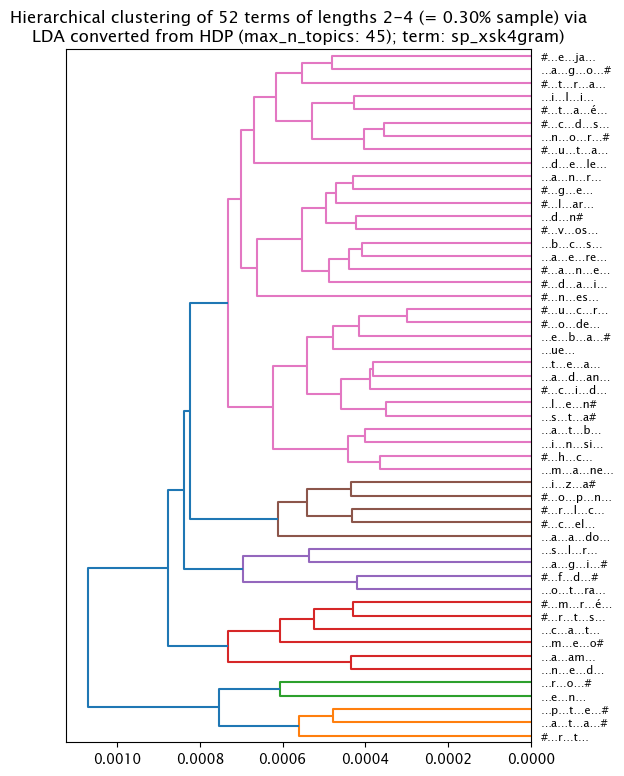

In [166]:
## term の階層クラスタリング: max_n_topics の値に拠ってparameters の最適値は異なる
HDP_helper.hc_clustering_terms_from_hdp (hdp45, diction, term_type = term_type, n_topics = 45, lowest_density = 0.0003, max_length = n_for_ngram, min_length = 2, gap_mark = gap_mark, sampling_rate = 0.003, check = False)

In [167]:
## HDP (n_topics = 90)
import gensim.models
import pyLDAvis.gensim

max_n_topics = 90
hdp90 = gensim.models.HdpModel(corpus, diction, T = max_n_topics,
                               random_state = 1)
vis_data90 = pyLDAvis.gensim.prepare(hdp90, corpus, diction)
pyLDAvis.display(vis_data90)

In [168]:
## save LDAvis output as a html file
#save_LDAvis = True
if save_LDAvis:
	lang_dir_name = target_lang_dict[target_lang_key].split()[0]
	vis_output = f"results/LDAvis/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-HDP-max_ntop{max_n_topics}-{term_type}{accent_status}.html"
	pyLDAvis.save_html(vis_data90, vis_output)

In [169]:
## save topic structures
if save_topic_structure:
    hdp_topics = hdp90.show_topics(num_topics = max_n_topics,
                                num_words = n_terms_to_save, formatted = False)
    hdp_dict = { tid: values for tid, values in hdp_topics }

    ## convert to Pandas dataframe
    topics_df = pd.DataFrame.from_dict(hdp_dict)
    hdp90_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
    topics_df.to_csv(hdp90_topics_out, header = False, index = None)
    print(f"saved: {hdp90_topics_out}")

In [170]:
## topic investigation
import numpy as np
import HDP_helper

target_hdp = hdp90
documents_topics = np.zeros([target_hdp.m_T, len(corpus)])
for doc_id, c in enumerate(corpus):
    for topic_id, prob in target_hdp[c]:
        documents_topics[topic_id][doc_id] = prob

## investigate topics
target_hdp.optimal_ordering()
for topic_id, probs in enumerate(documents_topics):
    print(f"==============")
    #topic_encoding = ", ".join(hdp.show_topic(topic_id))
    topic_t = target_hdp.print_topic(topic_id, topn = n_terms_to_show)
    print(f"topic_id {topic_id}: {HDP_helper.reformat_topic (topic_t, n_terms_to_show)}")
    print(f"nonzero count: ", len(probs.nonzero()[0]))
    for doc_id in probs.argsort()[::-1][:n_docs_to_show]:
        doc = doc_dict[doc_id]
        print(f"\t{probs[doc_id]:0.4f}: {doc}")

topic_id 0: 0.002 * o + 0.002 * #…o… + 0.001 * a + 0.001 * i + 0.001 * #…i…# + 0.001 * #…i… + 0.001 * …i…# + 0.001 * #…a…# + 0.001 * …a…# + 0.001 * s + 0.001 * #…a… + 0.001 * #…s… + 0.001 * e + 0.001 * …o…# + 0.001 * #…e… + 0.001 * #…o…# + 0.001 * #…e…# + 0.001 * …e…# + 0.001 * …s# + 0.001 * r
nonzero count:  149
	0.9981: #portarais#
	0.9981: #comediado#
	0.9980: #resumidos#
	0.9980: #acudidero#
	0.9980: #volteados#
	0.9980: #tabicamos#
	0.9979: #militemos#
	0.9979: #postinero#
	0.9979: #remolléis#
	0.9979: #arabicéis#
	0.9978: #cinericio#
	0.9978: #sombreéis#
	0.9978: #lastiméis#
	0.9977: #jacobinos#
	0.9977: #cobijamos#
topic_id 1: 0.002 * a + 0.002 * #…a… + 0.002 * …a…# + 0.002 * #…a…# + 0.002 * e + 0.002 * r + 0.002 * #…r… + 0.002 * …r…# + 0.002 * #…r…# + 0.001 * #…e… + 0.001 * #…a…r…# + 0.001 * …a…r…# + 0.001 * #…e…# + 0.001 * …e…# + 0.001 * …e…a… + 0.001 * …a…e… + 0.001 * #…a…e… + 0.001 * #…e…a… + 0.001 * n + 0.001 * #…ar…
nonzero count:  128
	0.9981: #platinara#
	0.9981: #denost

17476 rows remain after density filtering, discarding 0 rows
17443 rows remain after size filtering, discarding 33 rows
35 rows remain after size filtering, discarding 17408 rows


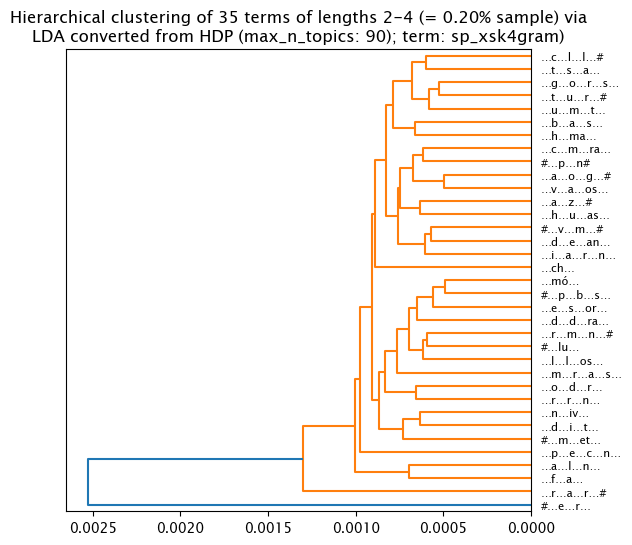

In [171]:
## term の階層クラスタリング: max_n_topics, term の値に拠ってparameters の最適値は異なる
HDP_helper.hc_clustering_terms_from_hdp (hdp90, diction, term_type = term_type, n_topics = 90, lowest_density = 0.0012, max_length = n_for_ngram, min_length = 2, gap_mark = gap_mark, sampling_rate = 0.002, check = False)